to hsv 1.8873441219329834
back 0.011182546615600586


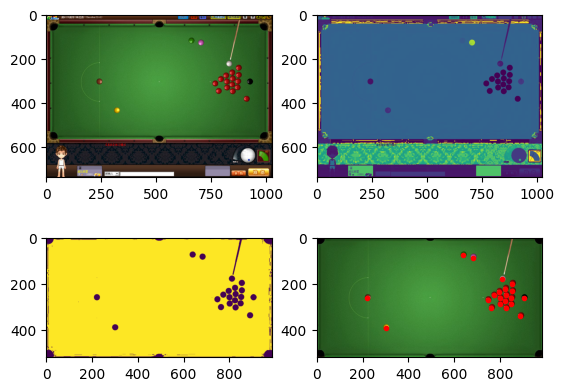

ball 0.2779273986816406
detect 0.0007474422454833984
[3 6 0 1 1 1 1 1 1 1 4 1 7 1 1 1 1 1 1 1 2]


In [1]:
from PIL import Image
from skimage.io import imread
from skimage import color
from time import time
import numpy as np
from numpy.linalg import norm
import scipy.ndimage as ndimg
import matplotlib.pyplot as plt

# RGB转换HSV空间
def rgb2hsv(rgb):
    hsv = np.zeros(rgb.shape, dtype=np.float32)
    cmax = rgb.max(axis=-1)
    #crng = rgb.ptp(axis=-1) # old
    crng = np.ptp(rgb, axis = -1)
    np.clip(cmax, 1, 255, out=hsv[:,:,1])
    np.divide(crng, hsv[:,:,1], out=hsv[:,:,1])
    np.divide(cmax, 255, out=hsv[:,:,2])
    maxidx = np.argmax(rgb, axis=-1).ravel()
    colrgb = rgb.reshape(-1,3)
    idx = np.arange(colrgb.shape[0])
    lut = np.array([[1,2,0],[2,0,1]], dtype=np.uint8)
    h = (colrgb[idx, lut[0][maxidx]]).astype(np.float32)
    h -= colrgb[idx, lut[1][maxidx]]
    h[h==0] = 1
    np.clip(crng, 1, 255, out=crng)
    h /= crng.ravel()
    h += np.array([0,2,4], dtype=np.uint8)[maxidx]
    h /= 6; h %= 1
    hsv[:,:,0] = h.reshape(hsv.shape[:2])
    return hsv

# 制作HSV索引表
def make_lut():
    arr = np.mgrid[0:256,0:256,0:256].reshape(3,-1).T
    arr = arr.astype(np.uint8)
    lut = rgb2hsv(arr.reshape(1,-1,3))
    lut = (lut[0,:,0]*255).astype(np.uint8)
    return lut.reshape(256,256,256)

# 利用索引进行RGB到HSV转换
def rgb2hsv_lut(rgb, lut=[None]):
    if lut[0] is None: lut[0] = make_lut()
    r,g,b = rgb.reshape(-1,3).T
    return lut[0][r,g,b].reshape(rgb.shape[:2])
    
# 计算角度
def angleX(v):
    a = np.arccos(v[:,0] / (norm(v[:,:2], axis=1)+1e-5))
    return np.where(v[:,1]>=0,a ,np.pi * 2 - a)

# 精确定位, 根据圆心和采样点，组建法方程，进行最小二乘估计
def exactly(O, r, pts):
    n = len(pts)
    B = np.zeros((n*2, n+3))
    L = np.zeros(n*2)
    appro = np.zeros(n+3)
    appro[:n] = angleX(pts-O)
    appro[n:] = [O[0], O[1], r]
    try:
        for i in range(2): # 两次迭代，确保达到稳定
            L[::2] = appro[n]+appro[-1]*np.cos(appro[:n])-pts[:,0]
            L[1::2] = appro[n+1]+appro[-1]*np.sin(appro[:n])-pts[:,1]
            B[range(0,n*2,2),range(n)] = -appro[-1]*np.sin(appro[:n])
            B[range(1,n*2,2),range(n)] = appro[-1]*np.cos(appro[:n])
            B[::2,n],B[1::2,n+1] = 1, 1
            B[::2,-1] = np.cos(appro[:n])
            B[1::2,-1] = np.sin(appro[:n])
            NN = np.linalg.inv(np.dot(B.T,B))
            x = np.dot(NN, np.dot(B.T,L))
            v = np.dot(B,x)-L
            appro -= x
    except:
        print(O, r, pts)
    if not(appro[-1]>5 and appro[-1]<50): 
        return (None, None), None
    return appro[[-3,-2]], appro[-1]

#a = np.arccos(v[:,0] / norm(v[:,:2], axis=1))
# 查找背景
def find_ground(img, tor=5):
    r, c = np.array(img.shape[:2])//2
    center = img[r-100:r+100, c-100:c+100]
    back = np.argmax(np.bincount(center.ravel()))
    msk = np.abs(img.astype(np.int16) - back)<tor
    lab, n = ndimg.label(msk)
    hist = np.bincount(lab.ravel())
    if hist[1:].max() < 1e4: return None
    if np.argmax(hist[1:])==0: return None
    msk = lab == np.argmax(hist[1:]) + 1
    sr, sc = ndimg.find_objects(msk)[0]
    loc = sr.start, sc.start
    size = sr.stop - loc[0], sc.stop - loc[1]
    return loc, size, sr, sc, msk[sr, sc]

# 查找一个球
def find_one(img, cs, r=18, a=20):
    h, w = img.shape
    if cs[0]<r+1 or cs[1]<r+1 or cs[0]>h-r-1 or cs[1]>w-r-1:
        return (None, None), None
    rs, pts = np.arange(r), []
    for i in np.linspace(0, np.pi*2, a, endpoint=False):
        rcs = rs[:,None] * (np.cos(i), np.sin(i)) + cs
        rcs = rcs.round().astype(int).T
        ns = rs[img[rcs[0], rcs[1]]]
        if len(ns)==0: continue
        pts.append(rcs.T[ns.min()])
    if len(pts)<10: return (None, None), None
    return exactly(cs, r, np.array(pts))

# 检测球
def find_ball(img):
    dist = ndimg.binary_dilation(img, np.ones((13, 13)))
    dist[:,[0,-1]] = 0; dist[[0,-1],:] = 0
    lab, n = ndimg.label(~dist)
    objs = ndimg.find_objects(lab)[1:]
    cs = [(i.start+i.stop, j.start+j.stop) for i,j in objs]
    balls = []
    for i in np.array(cs)/2:
        (r, c), ra = find_one(img, i)
        if not ra is None: balls.append([r, c, ra])
    if len(balls)==0: return balls
    balls = np.array(balls)
    balls[:,2] = balls[:,2].mean()-0.5
    return balls

# 提取颜色
def detect_color(img, balls, mode='snooker'):
    r = int(balls[0,2]) - 1
    rcs = np.mgrid[-r:r+1, -r:r+1].reshape(2,-1).T
    rcs = rcs[norm(rcs, axis=1) < r]
    colors = []
    for r,c in balls[:,:2]:
        rs, cs = (rcs + (int(r), int(c))).T
        colors.append(img[rs, cs])
    colors = np.array(colors).astype(np.int16)
    colors = np.sort(colors, axis=1)
    colors = colors[:,len(rcs)//4:-len(rcs)//4]
    if mode=='snooker':
        snklut = [21, 0, 34, 73, 12, 171, 221, 42]
        cs = [np.argmax(np.bincount(i)) for i in colors]
        diff = np.abs(np.array(cs)[:,None] - snklut)
        return np.argmin(diff, axis=-1)
    
    if mode=='black8':
        bins = np.array([np.bincount(i, minlength=256) for i in colors])
        mean = np.argmax(bins, axis=-1)
        std = (np.std(colors, axis=1)>1) + 1
        std[(std==1) & (np.abs(mean-42)<3)] = 7
        n = (np.abs(colors-28)<3).sum(axis=1)
        n = bins[:,25:30].max(axis=1)
        #print(mean)
        #print(np.bincount(colors[5]))
        #print(np.bincount(colors[9]))
        std[np.argmax(n)] = 0
        return std

# lut = np.load('lut.npy')
# 提取球桌信息
def extract_table(img, mode='snooker'):
    """
    提取球桌信息：先做色彩空间转换，调用find_ground找背景，调用find_ball找球，再用detect_color识别球的种类。
    """
    #hsv = (rgb2hsv(img[:,:,:3]) * 255).astype(np.uint8)
    hsv = rgb2hsv_lut(img)
    ground = find_ground(hsv)
    if ground is None: return '未检测到球桌，请勿遮挡'
    loc, size, sr, sc, back = ground
    balls = find_ball(back)
    if len(balls)==0: return '全部球已入袋'
    tps = detect_color(hsv[sr, sc], balls, mode)
    balls = np.hstack((balls, tps[:,None]))
    return loc, size, img[sr, sc], balls
    
if __name__ == '__main__':
    img = imread('window_capture_20250614_194521.png')[:,:,:3]
    start = time()
    #hsv = (rgb2hsv(img[:,:,:0]) * 255).astype(np.uint8)
    ax = plt.subplot(221)
    ax.imshow(img)

    hsv = rgb2hsv_lut(img)
    print('to hsv', time()-start)
    ax = plt.subplot(222)
    ax.imshow(hsv)

    start = time()
    loc, size, sr, sc, back = find_ground(hsv)
    print('back', time()-start)
    ax = plt.subplot(223)
    ax.imshow(back)

    start = time()
    balls = find_ball(back)

    ax = plt.subplot(224)
    ax.imshow(img[sr, sc])
    ax.plot(balls[:,1], balls[:,0], 'r.')

    plt.show()

    print('ball', time()-start)

    start = time()
    tps = detect_color(hsv[sr, sc], balls)
    
    print('detect', time()-start)
    print(tps)

(738, 1024, 3)
(738, 1024)
[15 15 15 ...  8  7 42]
back=80


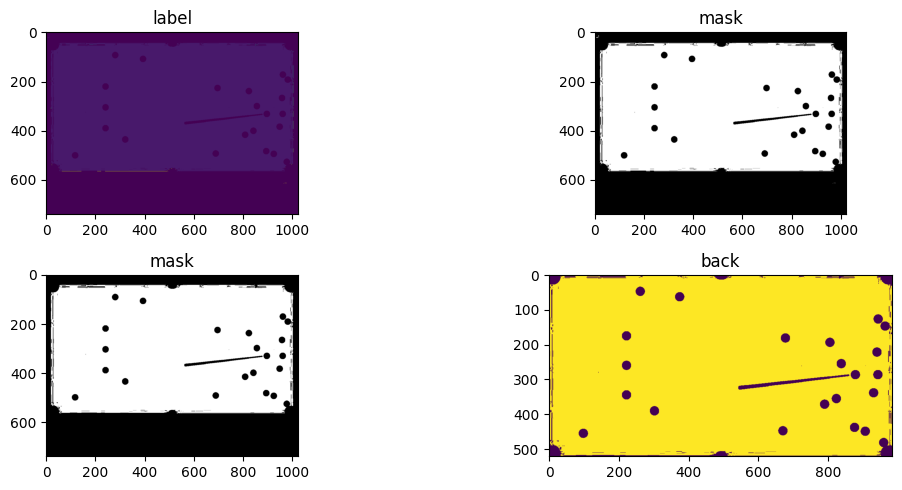

In [140]:
def find_ground1(img, tor=5):
    r, c = np.array(img.shape[:2])//2
    center = img[r-100:r+100, c-100:c+100]
    back = np.argmax(np.bincount(center.ravel()))
    msk = np.abs(img.astype(np.int16) - back)<tor
    lab, n = ndimg.label(msk)
    hist = np.bincount(lab.ravel())
    if hist[1:].max() < 1e4: return None
    if np.argmax(hist[1:])==0: return None
    msk = lab == np.argmax(hist[1:]) + 1
    sr, sc = ndimg.find_objects(msk)[0]
    loc = sr.start, sc.start
    size = sr.stop - loc[0], sc.stop - loc[1]
    return loc, size, sr, sc, msk[sr, sc]

img = imread('window_capture_20250615_173243.png')[:,:,:3]
print(img.shape)
img = rgb2hsv_lut(img)
print(img.shape)
r, c = np.array(img.shape[:2])//2  # r=738//2=369   c=512 
center = img[:,:]  # 80
print(center.ravel())
# plt.imshow(center)
back = np.argmax(np.bincount(center.ravel()))
print(f"back={back}")
msk = np.abs(img.astype(np.int16) - back)<5
lab, n = ndimg.label(msk)

hist = np.bincount(lab.ravel())

msk2 = lab == np.argmax(hist[1:]) + 1  # 提取出最大连通区域
objs = ndimg.find_objects(msk2)  # 经过msk 提取lab ， 又从lab中的最大连通分量重新构造msk，此时的msk2 基本上就是一个连通的目标，提取objects，出来的结果长度应该就是1
# len(objs) 为 1  [(slice(40, 448, None), slice(15, 785, None))]
sr, sc = objs[0]   #  objs[0]是一个边界框，是两个切片对象组成的二元组，分别对应行和列。



# 同时显示原始图像和掩码
plt.figure(figsize=(12, 5))

plt.subplot(221); plt.imshow(lab); plt.title('label')
plt.subplot(222); plt.imshow(msk, cmap='gray'); plt.title('mask')
plt.subplot(223); plt.imshow(msk2, cmap='gray'); plt.title('mask')
plt.subplot(224); plt.imshow(msk2[sr,sc]); plt.title('back')
plt.tight_layout(); plt.show()



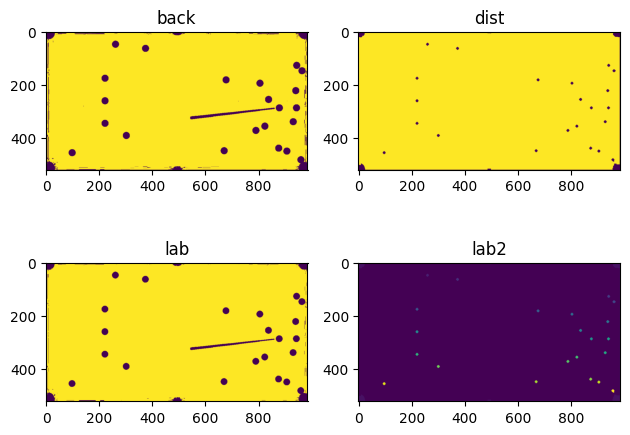

In [124]:
# 找球阶段的输入： msk2[sr,sc]
back = msk[sr,sc]
dist = ndimg.binary_dilation(back, np.ones((13, 13)))
dist2 = ndimg.binary_dilation(back, np.ones((2, 2)))  # 经过背景膨胀，再提取球的连通分量，可以得到球中心坐标，但是不能得到球半径。要想得到球半径，要从未经背景膨胀的图
dist[:,[0,-1]] = 0; dist[[0,-1],:] = 0
lab, n = ndimg.label(~dist)


plt.subplot(221); plt.imshow(back); plt.title('back')
plt.subplot(222); plt.imshow(dist); plt.title('dist')
plt.subplot(223); plt.imshow(dist2); plt.title('lab')
plt.subplot(224); plt.imshow(lab); plt.title('lab2')
plt.tight_layout(); plt.show()

In [116]:
objs = ndimg.find_objects(lab)[1:]
len(objs) # 输出为22，objs就对应着22个球（22个连通区域）

22

In [129]:
lab1, n = ndimg.label(~back)
objs_acr = ndimg.find_objects(lab1)[1:]

ball_info = [[( (obj[0].start + obj[0].stop) // 2, (obj[1].start + obj[1].stop) // 2 ),  # 中心坐标 (row, col)
             (obj[0].stop - obj[0].start, obj[1].stop - obj[1].start)] for obj in objs_acr]  # 边界尺寸 (高度, 宽度)
ball_info = np.array(ball_info)
for i in ball_info:
    if i[1][0] + i[1][1] > 50 and abs(i[1][0] - i[1][1]) < 10:  # 过滤掉尺寸不合适的球
        print(f"center: {i[0]}, size: {i[1]}")  # 输出每个球的中心坐标和尺寸

center: [ 49 261], size: [27 27]
center: [ 65 374], size: [26 27]
center: [128 942], size: [27 27]
center: [149 962], size: [26 27]
center: [177 222], size: [26 26]
center: [183 677], size: [27 26]
center: [195 804], size: [27 27]
center: [223 939], size: [27 26]
center: [256 837], size: [27 26]
center: [261 222], size: [27 26]
center: [288 877], size: [26 27]
center: [288 941], size: [26 27]
center: [340 929], size: [26 27]
center: [346 222], size: [26 26]
center: [356 822], size: [27 27]
center: [372 789], size: [27 27]
center: [391 302], size: [27 26]
center: [439 875], size: [26 26]
center: [448 669], size: [27 27]
center: [450 905], size: [27 27]
center: [456  98], size: [27 27]
center: [503  22], size: [36 45]


In [133]:
def find_ball(img):
    dist = ndimg.binary_dilation(img, np.ones((13, 13)))
    dist[:,[0,-1]] = 0; dist[[0,-1],:] = 0
    lab, n = ndimg.label(~dist)
    objs = ndimg.find_objects(lab)[1:]
    cs = [(i.start+i.stop, j.start+j.stop) for i,j in objs]
    balls = []
    for i in np.array(cs)/2:
        (r, c), ra = find_one(img, i)
        if not ra is None: balls.append([r, c, ra])
    if len(balls)==0: return balls
    balls = np.array(balls)
    # balls[:,2] = balls[:,2].mean()-0.5
    return balls

balls = find_ball(back)
balls = np.array(balls)
balls

array([[ 49.04773111, 260.82633212,  14.01418653],
       [ 64.42102936, 373.68294216,  13.96781295],
       [128.20600421, 942.05716691,  13.97688541],
       [148.6145082 , 962.30406822,  14.08551637],
       [176.46203761, 221.46200979,  13.98515569],
       [182.68296866, 676.42103163,  13.96781338],
       [195.04219928, 803.82948043,  13.90961314],
       [222.92821371, 938.559028  ,  14.00321924],
       [255.9662735 , 836.33601032,  13.87596032],
       [260.92589339, 221.42788515,  13.93209711],
       [287.48252173, 876.7064402 ,  13.98395595],
       [287.52053736, 941.15928599,  14.06466683],
       [339.42784515, 928.92589243,  13.93209707],
       [345.46203761, 221.46200979,  13.98515569],
       [356.05716736, 822.20600673,  13.97688996],
       [372.0348375 , 788.85482187,  14.11802669],
       [391.16558197, 301.56900991,  13.94972075],
       [438.67009406, 874.30590157,  13.99078929],
       [448.2452193 , 669.24521748,  14.00103574],
       [449.56897098, 905.16558

In [ ]:
def detect_color(img, balls, mode='snooker'):
    r = int(balls[0,2]) - 1
    rcs = np.mgrid[-r:r+1, -r:r+1].reshape(2,-1).T
    rcs = rcs[norm(rcs, axis=1) < r]
    colors = []
    for r,c in balls[:,:2]:
        rs, cs = (rcs + (int(r), int(c))).T
        colors.append(img[rs, cs])
    colors = np.array(colors).astype(np.int16)
    colors = np.sort(colors, axis=1)
    colors = colors[:,len(rcs)//4:-len(rcs)//4]
    if mode=='snooker':
        snklut = [21, 0, 34, 73, 12, 171, 221, 42]
        cs = [np.argmax(np.bincount(i)) for i in colors]
        diff = np.abs(np.array(cs)[:,None] - snklut)
        return np.argmin(diff, axis=-1)
    
    if mode=='black8':
        bins = np.array([np.bincount(i, minlength=256) for i in colors])
        mean = np.argmax(bins, axis=-1)
        std = (np.std(colors, axis=1)>1) + 1
        std[(std==1) & (np.abs(mean-42)<3)] = 7
        n = (np.abs(colors-28)<3).sum(axis=1)
        n = bins[:,25:30].max(axis=1)
        #print(mean)
        #print(np.bincount(colors[5]))
        #print(np.bincount(colors[9]))
        std[np.argmax(n)] = 0
        return std

hsvbg = img[sr, sc]
r = 13
rcs = np.mgrid[-r:r+1, -r:r+1].reshape(2,-1).T
rcs = rcs[norm(rcs, axis=1) < r]
colors = []
for r,c in balls[:,:2]:
    rs, cs = (rcs + (int(r), int(c))).T
    colors.append(hsvbg[rs, cs])
colors = np.array(colors).astype(np.int16)
colors = np.sort(colors, axis=1)
colors = colors[:,len(rcs)//4:-len(rcs)//4]
cs = [np.argmax(np.bincount(i)) for i in colors]




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [154]:
balls = np.array(balls)
cs = np.array(cs)
balls_cs = np.hstack((balls, cs[:,None]))
balls_cs

array([[ 49.04773111, 260.82633212,  14.01418653, 221.        ],
       [ 64.42102936, 373.68294216,  13.96781295,   0.        ],
       [128.20600421, 942.05716691,  13.97688541,   0.        ],
       [148.6145082 , 962.30406822,  14.08551637,   0.        ],
       [176.46203761, 221.46200979,  13.98515569,  73.        ],
       [182.68296866, 676.42103163,  13.96781338,   0.        ],
       [195.04219928, 803.82948043,  13.90961314,   0.        ],
       [222.92821371, 938.559028  ,  14.00321924,  42.        ],
       [255.9662735 , 836.33601032,  13.87596032,   0.        ],
       [260.92589339, 221.42788515,  13.93209711,  12.        ],
       [287.48252173, 876.7064402 ,  13.98395595,  21.        ],
       [287.52053736, 941.15928599,  14.06466683,   0.        ],
       [339.42784515, 928.92589243,  13.93209707,   0.        ],
       [345.46203761, 221.46200979,  13.98515569,  34.        ],
       [356.05716736, 822.20600673,  13.97688996,   0.        ],
       [372.0348375 , 788